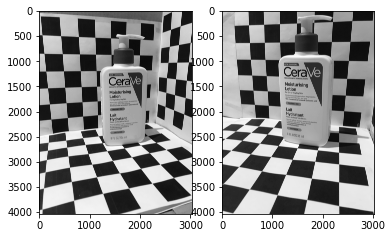

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

def drawlines(img1,img2,lines,pts1,pts2):
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv.cvtColor(img1,cv.COLOR_GRAY2BGR)
    img2 = cv.cvtColor(img2,cv.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = (255,0,0)
        color1 = (0,0,255)
        # color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv.line(img1, (x0,y0), (x1,y1), color,3)
        img1 = cv.circle(img1,tuple(pt1),40,color1,-1)
        img2 = cv.circle(img2,tuple(pt2),40,color1,-1)
    return img1,img2

img1 = cv.imread(r'../images2/FD_object/6.jpg',cv.IMREAD_GRAYSCALE)  #queryimage # left image
img2 = cv.imread(r'../images2/FD_object/2.jpg',cv.IMREAD_GRAYSCALE) #trainimage # right image

plt.figure()
plt.subplot(1,2,1)
plt.imshow(img1)
plt.gray();
plt.subplot(1,2,2)
plt.imshow(img2)
plt.gray();

[[ 511 2428]
 [ 811 2771]
 [ 859 2474]
 [1110 2369]
 [1393 1287]
 [1393 1287]
 [1401 1774]
 [1401 1774]
 [1402 1825]
 [1407 1816]
 [1410 1764]
 [1410 1764]
 [1410 1821]
 [1411 1833]
 [1413 1759]
 [1413 1759]
 [1416 1867]
 [1418 2311]
 [1418 2311]
 [1419 1506]
 [1422 2321]
 [1422 1260]
 [1423 1516]
 [1425 1847]
 [1428 1767]
 [1429 1880]
 [1429 2134]
 [1429 1873]
 [1429 1844]
 [1429 1844]
 [1432 1092]
 [1432 1278]
 [1433 2282]
 [1435 1712]
 [1436 1265]
 [1436 1260]
 [1437 1273]
 [1437 1665]
 [1438 1772]
 [1440 1517]
 [1440 1806]
 [1442 2147]
 [1443 2084]
 [1443 1791]
 [1445 1639]
 [1447 2091]
 [1447 2094]
 [1448 1502]
 [1450 1506]
 [1451 1513]
 [1451 1835]
 [1471 2058]
 [1471 2078]
 [1474 1863]
 [1475 1835]
 [1475 1835]
 [1484 1508]
 [1484 2302]
 [1490 1266]
 [1497 1656]
 [1498 1769]
 [1499 1681]
 [1501 2331]
 [1502 2068]
 [1503 1508]
 [1503 1268]
 [1503 1268]
 [1504 2051]
 [1506 1512]
 [1507 1338]
 [1508 2150]
 [1508 1955]
 [1511 2343]
 [1521 2268]
 [1521 2268]
 [1522 1511]
 [1522 1511]

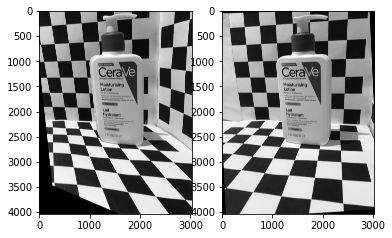

In [2]:

sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

pts1=[]
pts2=[]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.45*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
print(pts1)
F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
print(F)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

h1, w1 = img1.shape
h2, w2 = img2.shape
thresh = 0.1
_, H1, H2 = cv.stereoRectifyUncalibrated(
    np.float32(pts1), np.float32(pts2), F, imgSize=(w1, h1), threshold=thresh,
)

############## Undistort (Rectify) ##############
imgL_undistorted = cv.warpPerspective(img1, H1, (w1, h1))
imgR_undistorted = cv.warpPerspective(img2, H2, (w2, h2))

plt.figure()
plt.subplot(1,2,1)
plt.imshow(imgL_undistorted)
plt.gray();
plt.subplot(1,2,2)
plt.imshow(imgR_undistorted)
plt.gray();

In [15]:
H1

array([[-3.53109537e-03, -5.17274097e-04,  6.19755536e-01],
       [ 7.32779631e-04, -4.92320129e-03,  7.51954962e-01],
       [ 6.67161335e-07, -1.40934746e-07, -4.94304234e-03]])

In [16]:
H2

array([[ 1.00983986e+00,  4.73606996e-02, -1.10357046e+02],
       [-3.22639616e-02,  9.99586010e-01,  4.96177145e+01],
       [ 7.23400924e-06,  3.39269373e-07,  9.88378211e-01]])

In [ ]:
results_inner = {'type': 'rect', 'res': bboxes, 'len': len(bboxes), 'annoBegin': 1, 'startFrame': 1}

# Embed data in MATLAB cell array
obj_arr = np.zeros((1,), dtype = np.object)
obj_arr[0] = results_inner

# Save file
sio.savemat('np_cells.mat', {'results': obj_arr})


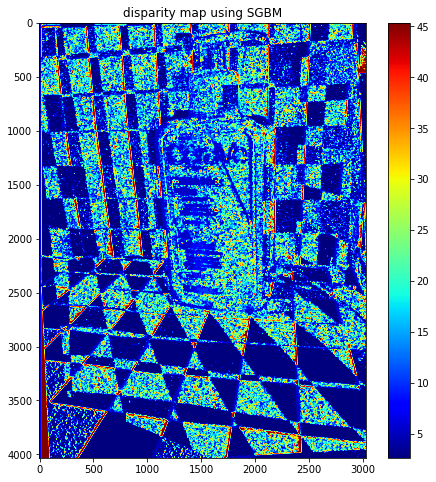

In [12]:
# Using StereoSGBM
# Set disparity parameters. Note: disparity range is tuned according to
#  specific parameters obtained through trial and error.
win_size = 2
min_disp = 2
max_disp = 18
num_disp = max_disp - min_disp  # Needs to be divisible by 16
stereo = cv.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=11,
    uniquenessRatio=3,
    speckleWindowSize=5,
    speckleRange=5,
    disp12MaxDiff=2,
    P1=8 * 3 * win_size ** 2,
    P2=8 * 3 * win_size ** 2,
)
disparity_SGBM = stereo.compute(imgL_undistorted, imgR_undistorted) / 6;
# disparity_SGBM[disparity_SGBM > 175] = 175;
plt.figure(figsize=(8,8))
plt.imshow(disparity_SGBM)
plt.title("disparity map using SGBM")
plt.colorbar()
plt.jet();

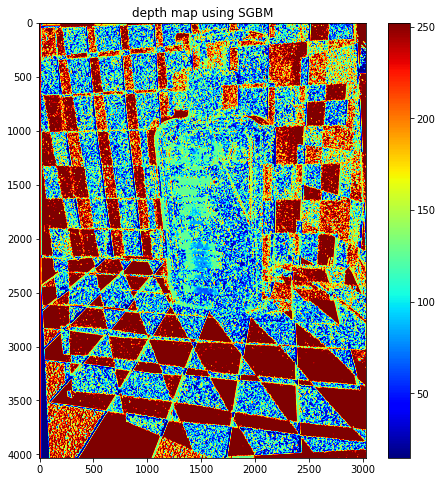

In [14]:
depthMap = 0.2 * (30*4 * 28) / (disparity_SGBM);
plt.figure(figsize=(8,8))
plt.imshow(depthMap)
plt.title("depth map using SGBM")
plt.colorbar()
plt.jet()


In [ ]:

sift1 = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift1.detectAndCompute(imgL_undistorted,None)
kp2, des2 = sift1.detectAndCompute(imgR_undistorted,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

pts1=[]
pts2=[]
# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.45*n.distance:
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

F, mask = cv.findFundamentalMat(pts1,pts2,cv.FM_LMEDS)
print('')
print(F)
# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

lines1 = cv.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5, img6 = drawlines(imgL_undistorted,imgR_undistorted,lines1,pts1,pts2)

lines2 = cv.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3, img4 = drawlines(imgR_undistorted,imgL_undistorted,lines2,pts2,pts1)
plt.figure('rectification')
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
# plt.title("Vanishing points and horizon")
plt.savefig('task5.1.png')
plt.show()
